In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [2]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

### Reading the Dataset

In [3]:
df = (spark.read
          .format("csv")
          .option('header', 'true')
          .load("./datasets/US-Chronic-dataset.csv"))

In [4]:
#df.toPandas().head()

In [5]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import MultilabelClassificationEvaluator
from pyspark.ml import Pipeline

### Selecting Features and Casting it into required Dtype

In [6]:
columns  = df.columns

dataset = df.select(col(columns[3]).cast('string'),
                    col(columns[4]).cast('string'),
                    col(columns[5]).cast('string'),
                    col(columns[6]).cast('float'),
                    col(columns[7]).cast('float'),
                    col(columns[8]).cast('float'),
                    col(columns[9]).cast('string'),
                    col(columns[10]).cast('string'),
                    col(columns[11]).cast('string'),
                    col(columns[12]).cast('string'),
                    col(columns[13]).cast('string'),
                    col(columns[14]).cast('float'),
                    col(columns[15]).cast('float'),
                   )

In [7]:
# inputCols for StringIndexer
string_col = [
    'DataSource','DataValueUnit','DataValueTypeID',
    'QuestionID','LocationID','StratificationCategoryID1',
    'StratificationID1','TopicID'
]

#outputCols for StringIndexer
string_col_output = [
    'DataSourceIndex','DataValueUnitIndex','DataValueTypeIDIndex',
    'QuestionIDIndex','LocationIDIndex','StratificationCategoryID1Index',
    'StratificationID1Index','TopicIDIndex'
]

#inputCols for OneHotEncoder
string_col_encode_input = [
    'DataSourceIndex','DataValueUnitIndex','DataValueTypeIDIndex',
    'QuestionIDIndex','LocationIDIndex','StratificationCategoryID1Index',
    'StratificationID1Index'
]

#outputCols for OneHotEncoder
string_col_encoded = [
    'DataSourceVec','DataValueUnitVec','DataValueTypeIDVec',
    'QuestionIDVec','LocationIDVec','StratificationCategoryID1Vec',
    'StratificationID1Vec'
]

#inputCols for VectorAssembler
features_to_assemble = string_col_encoded + ['DataValue','LowConfidenceLimit','HighConfidenceLimit','Geo_lat','Geo_lon']

### Feature Transformation

In [8]:
indexer = StringIndexer(inputCols= string_col, outputCols=string_col_output)
encoder = OneHotEncoder(inputCols=string_col_encode_input, outputCols=string_col_encoded)
vectorAssembler = VectorAssembler(inputCols=features_to_assemble,
                                  outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)
scaler = StandardScaler(inputCol="features_norm", outputCol="features_norm_scaled")
pipeline = Pipeline(stages=[indexer, encoder, vectorAssembler, normalizer,scaler])
final_df = pipeline.fit(dataset).transform(dataset)

### Splitting the Dataset into Training data and Test data

In [9]:
(training_data, test_data) = final_df.randomSplit([0.8,0.2],seed=1234)

### Building the Model

In [10]:
rfc = RandomForestClassifier()
param_grid = (ParamGridBuilder()
              .baseOn({rfc.labelCol : 'TopicIDIndex'})
              .baseOn([rfc.predictionCol, 'pred_rfc'])
              .baseOn([rfc.featuresCol, 'features_norm'])
              .addGrid(rfc.maxDepth, [7,10,15,20,30]).build())

evaluator = MulticlassClassificationEvaluator(labelCol= 'TopicIDIndex',predictionCol= 'pred_rfc')

cv = CrossValidator(estimator=rfc, estimatorParamMaps=param_grid, evaluator=evaluator,seed=0,parallelism=2)

### Training the Model

In [11]:
cvModel = cv.fit(training_data)

In [12]:
cvModel.avgMetrics

[0.6973069875602796,
 0.8017472531901317,
 0.8840126290184793,
 0.948660583153587,
 0.9874816855658695]

### Evaluating the Model Using Different Evaluation Metrices

In [13]:
evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "accuracy"})

0.9863996306949327

In [14]:
evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "f1"})

0.9863540681712097

In [15]:
evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "precisionByLabel"})

0.9994152046783625

In [16]:
evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "recallByLabel"})

0.9949543954977683

### Best Params

In [17]:
cvModel.bestModel.getMaxDepth()

30

### Saving the Trained Model

In [18]:
path= r'./SavedModels/RFClassifier_model'
cvModel.save(path)

### Loading the Trained Model

In [19]:
#rfc_model = CrossValidatorModel.read().load(path)

### Result Summary

In [20]:
import pandas as pd

summary_={
    'accuracy' : evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "accuracy"}),
    'f1-score' : evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "f1"}),
    'precision' : evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "precisionByLabel"}),
    'recall' : evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "recallByLabel"})
}

summary = pd.Series(summary_)
summary

accuracy     0.986400
f1-score     0.986354
precision    0.999415
recall       0.994954
dtype: float64

### Plotting Feature Importance Curve

In [21]:
features= ['DataSource_BRFSS', 'DataSource_Birth Certificate, NVSS',
       'DataSource_CDC School Health Profiles',
       'DataSource_CMS Part A Claims Data',
       'DataSource_Death certificate', 'DataSource_NSCH',
       'DataSource_NVSS', 'DataSource_PRAMS',
       'DataSource_State Emergency Department Data',
       'DataSource_State Inpatient Data',
       'DataSource_Statewide central cancer registries',
       'DataSource_YRBSS', 'DataValueUnit_%', 'DataValueUnit_Number',
       'DataValueUnit_cases per 1,000',
       'DataValueUnit_cases per 1,000,000',
       'DataValueUnit_cases per 10,000',
       'DataValueUnit_cases per 100,000', 'DataValueUnit_per 100,000',
       'DataValueTypeID_AgeAdjMean', 'DataValueTypeID_AgeAdjPrev',
       'DataValueTypeID_AgeAdjRate', 'DataValueTypeID_AvgAnnAgeAdjRate',
       'DataValueTypeID_AvgAnnCrdRate', 'DataValueTypeID_CrdMean',
       'DataValueTypeID_CrdPrev', 'DataValueTypeID_CrdRate',
       'DataValueTypeID_Mean', 'DataValueTypeID_Median',
       'DataValueTypeID_Prct', 'DataValueTypeID_Prev',
       'QuestionID_ALC1_1', 'QuestionID_ALC1_2', 'QuestionID_ALC2_1',
       'QuestionID_ALC2_2', 'QuestionID_ALC2_3', 'QuestionID_ALC3_0',
       'QuestionID_ALC4_0', 'QuestionID_ALC5_1', 'QuestionID_ALC5_2',
       'QuestionID_ALC6_0', 'QuestionID_ART1_1', 'QuestionID_ART1_2',
       'QuestionID_ART1_3', 'QuestionID_ART1_4', 'QuestionID_ART2_0',
       'QuestionID_ART3_0', 'QuestionID_ART4_0', 'QuestionID_ART5_0',
       'QuestionID_AST1_1', 'QuestionID_AST1_2', 'QuestionID_AST2_1',
       'QuestionID_AST3_1', 'QuestionID_AST4_1', 'QuestionID_AST5_1',
       'QuestionID_AST5_2', 'QuestionID_AST6_1', 'QuestionID_AST6_2',
       'QuestionID_CAN10_1', 'QuestionID_CAN10_2', 'QuestionID_CAN11_1',
       'QuestionID_CAN11_2', 'QuestionID_CAN1_0', 'QuestionID_CAN2_1',
       'QuestionID_CAN2_2', 'QuestionID_CAN3_0', 'QuestionID_CAN4_1',
       'QuestionID_CAN4_2', 'QuestionID_CAN5_1', 'QuestionID_CAN5_2',
       'QuestionID_CAN6_1', 'QuestionID_CAN6_2', 'QuestionID_CAN7_1',
       'QuestionID_CAN7_2', 'QuestionID_CAN8_1', 'QuestionID_CAN8_2',
       'QuestionID_CAN9_1', 'QuestionID_CAN9_2', 'QuestionID_CKD1_0',
       'QuestionID_CKD3_0', 'QuestionID_COPD1_1', 'QuestionID_COPD1_2',
       'QuestionID_COPD2_0', 'QuestionID_COPD2_0_1', 'QuestionID_COPD3_0',
       'QuestionID_COPD3_0_1', 'QuestionID_COPD4_0',
       'QuestionID_COPD4_0_1', 'QuestionID_COPD5_1', 'QuestionID_COPD5_2',
       'QuestionID_COPD5_3', 'QuestionID_COPD5_4', 'QuestionID_COPD6_1',
       'QuestionID_COPD6_2', 'QuestionID_COPD7_0', 'QuestionID_COPD8_0',
       'QuestionID_CVD10_1', 'QuestionID_CVD10_2', 'QuestionID_CVD1_1',
       'QuestionID_CVD1_2', 'QuestionID_CVD1_3', 'QuestionID_CVD1_4',
       'QuestionID_CVD1_5', 'QuestionID_CVD2_0', 'QuestionID_CVD3_1',
       'QuestionID_CVD3_2', 'QuestionID_CVD4_0', 'QuestionID_CVD5_0',
       'QuestionID_CVD6_1', 'QuestionID_CVD6_2', 'QuestionID_CVD7_0',
       'QuestionID_CVD8_0', 'QuestionID_CVD9_1', 'QuestionID_CVD9_2',
       'QuestionID_DIA10_0', 'QuestionID_DIA11_1', 'QuestionID_DIA11_2',
       'QuestionID_DIA11_3', 'QuestionID_DIA12_1', 'QuestionID_DIA12_2',
       'QuestionID_DIA13_1', 'QuestionID_DIA13_2', 'QuestionID_DIA1_1',
       'QuestionID_DIA1_2', 'QuestionID_DIA2_1', 'QuestionID_DIA2_2',
       'QuestionID_DIA3_1', 'QuestionID_DIA3_2', 'QuestionID_DIA4_0',
       'QuestionID_DIA5_0', 'QuestionID_DIA6_0', 'QuestionID_DIA7_0',
       'QuestionID_DIA8_0', 'QuestionID_DIA9_0', 'QuestionID_IMM1_0',
       'QuestionID_MTH1_0', 'QuestionID_MTH2_0', 'QuestionID_MTH3_0',
       'QuestionID_NPAW10_0', 'QuestionID_NPAW11_1',
       'QuestionID_NPAW11_2', 'QuestionID_NPAW11_3',
       'QuestionID_NPAW11_4', 'QuestionID_NPAW12_1',
       'QuestionID_NPAW12_2', 'QuestionID_NPAW13_1',
       'QuestionID_NPAW13_2', 'QuestionID_NPAW13_4', 'QuestionID_NPAW1_2',
       'QuestionID_NPAW21_0', 'QuestionID_NPAW2_1', 'QuestionID_NPAW2_2',
       'QuestionID_NPAW2_3', 'QuestionID_NPAW3_1', 'QuestionID_NPAW3_2',
       'QuestionID_NPAW4_2', 'QuestionID_NPAW5_1', 'QuestionID_NPAW5_2',
       'QuestionID_OLD1_0', 'QuestionID_OLD3_1', 'QuestionID_OLD3_2',
       'QuestionID_ORH1_2', 'QuestionID_ORH2_1', 'QuestionID_ORH4_1',
       'QuestionID_ORH4_2', 'QuestionID_ORH4_3', 'QuestionID_OVC1_1',
       'QuestionID_OVC1_2', 'QuestionID_OVC1_3', 'QuestionID_OVC5_0',
       'QuestionID_OVC6_1', 'QuestionID_OVC6_2', 'QuestionID_OVC7_1',
       'QuestionID_OVC7_2', 'QuestionID_OVC8_0', 'QuestionID_RPH1_0',
       'QuestionID_RPH2_0', 'QuestionID_RPH3_0', 'QuestionID_TOB11_1',
       'QuestionID_TOB11_2', 'QuestionID_TOB1_1', 'QuestionID_TOB1_2',
       'QuestionID_TOB1_3', 'QuestionID_TOB1_4', 'QuestionID_TOB2_1',
       'QuestionID_TOB2_2', 'QuestionID_TOB3_0', 'QuestionID_TOB9_0',
       'LocationID_1', 'LocationID_10', 'LocationID_11', 'LocationID_12',
       'LocationID_13', 'LocationID_15', 'LocationID_16', 'LocationID_17',
       'LocationID_18', 'LocationID_19', 'LocationID_2', 'LocationID_20',
       'LocationID_21', 'LocationID_22', 'LocationID_23', 'LocationID_24',
       'LocationID_25', 'LocationID_26', 'LocationID_27', 'LocationID_28',
       'LocationID_29', 'LocationID_30', 'LocationID_31', 'LocationID_32',
       'LocationID_33', 'LocationID_34', 'LocationID_35', 'LocationID_36',
       'LocationID_37', 'LocationID_38', 'LocationID_39', 'LocationID_4',
       'LocationID_40', 'LocationID_41', 'LocationID_42', 'LocationID_44',
       'LocationID_45', 'LocationID_46', 'LocationID_47', 'LocationID_48',
       'LocationID_49', 'LocationID_5', 'LocationID_50', 'LocationID_51',
       'LocationID_53', 'LocationID_54', 'LocationID_55', 'LocationID_56',
       'LocationID_6', 'LocationID_66', 'LocationID_72', 'LocationID_9',
       'LocationID_1', 'LocationID_10', 'LocationID_11', 'LocationID_12',
       'LocationID_13', 'LocationID_15', 'LocationID_16', 'LocationID_17',
       'LocationID_18', 'LocationID_19', 'LocationID_2', 'LocationID_20',
       'LocationID_21', 'LocationID_22', 'LocationID_23', 'LocationID_24',
       'LocationID_25', 'LocationID_26']

featureImportances= cvModel.bestModel.featureImportances.values

In [22]:
series= pd.Series(featureImportances,features)
df = pd.DataFrame(series,columns=['FeatureImportance'])

In [23]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


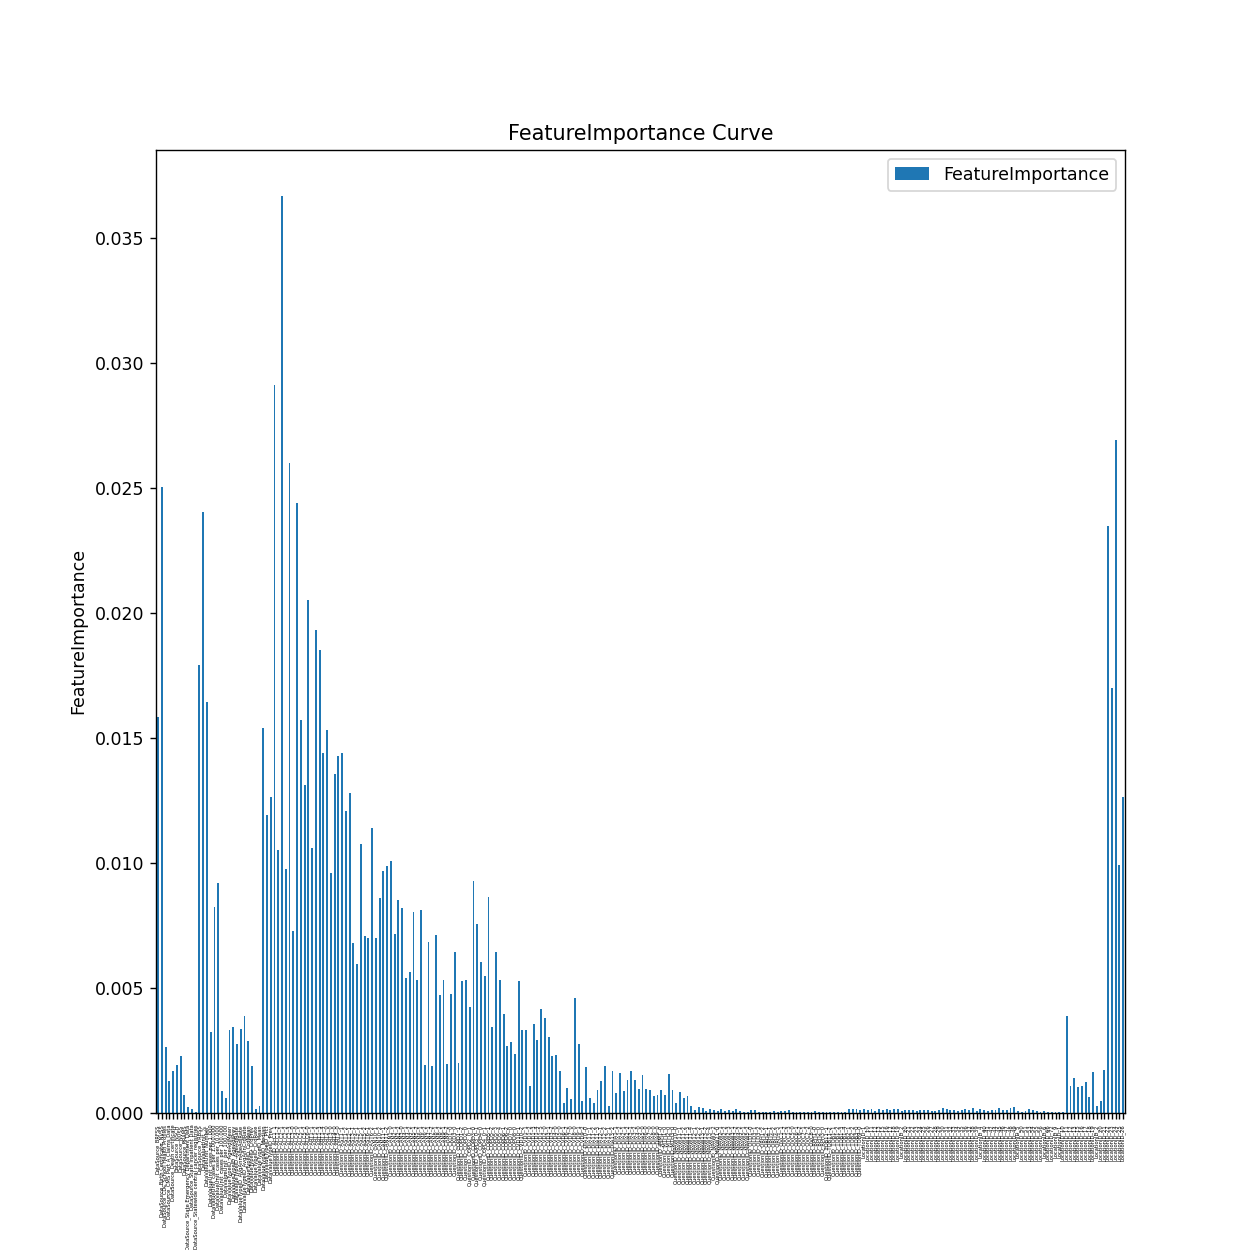

In [24]:
ax=df.plot.bar(figsize=(10,10),title='FeatureImportance Curve',ylabel='FeatureImportance',xlabel='Features')
ax.xaxis.set_tick_params(labelsize=3)